# Problem Definition

According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.

This dataset is used to predict whether a patient is **likely to get stroke** based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.
* id: Unique identifier
* gender: "Male" or "Female" or "Other"
* age: age of the patient
* hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
* heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
* ever_married: "No" or "Yes"
* work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
* Residence_type: "Rural" or "Urban"
* avg_glucose_level: average glucose level in blood
* bmi: body mass index
* smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
* stroke: 1 if the patient had a stroke or 0 if not

<"Unknown" in the smoking_status means that the information is unavailable for this patient>



# Import Libraries

In [46]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import plotly.express as px
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder,StandardScaler,PowerTransformer, MinMaxScaler, RobustScaler
from sklearn.model_selection import KFold, cross_val_predict, train_test_split,GridSearchCV,cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, Ridge,ElasticNet
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, log_loss, recall_score, accuracy_score, precision_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.feature_selection import SelectKBest,SelectPercentile,f_classif,f_regression,mutual_info_regression
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.impute import SimpleImputer
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.cluster import KElbowVisualizer

# Date Gathering

* Read the dataset

In [2]:
PATH = "D:\\Learn\\Uni\\ML\\CapstoneProject\\data\\healthcare-dataset-stroke-data.csv"

df = pd.read_csv(PATH)
df.head() 

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# Data Preparation

* Get basic information from the dataset

-> Let's start by standardizing all column name

In [3]:
df.columns = df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5104 entries, 0 to 5103
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5104 non-null   int64  
 1   gender             5104 non-null   object 
 2   age                5104 non-null   float64
 3   hypertension       5104 non-null   int64  
 4   heart_disease      5104 non-null   int64  
 5   ever_married       5104 non-null   object 
 6   work_type          5104 non-null   object 
 7   residence_type     5104 non-null   object 
 8   avg_glucose_level  5104 non-null   float64
 9   bmi                4903 non-null   float64
 10  smoking_status     5104 non-null   object 
 11  stroke             5104 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 478.6+ KB


* We have 5110 instances with the 11 features and 1 target variable.
* We have both  numerical and categorical variables (8 numerical, 4 categorical).
* The most important column is our target variable "stroke".
* Target variable is coded as 1 for positive cases and 0 for negative cases.
* "Hypertension" and "heart disease" columns are coded like "stroke" column.

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,5104.0,36496.701215,21161.207853,67.00,17737.5000,36898.500,54625.75,72940.00
age,5104.0,43.213754,22.621771,0.08,25.0000,45.000,61.00,82.00
hypertension,5104.0,0.097375,0.296496,0.00,0.0000,0.000,0.00,1.00
heart_disease,5104.0,0.054075,0.226188,0.00,0.0000,0.000,0.00,1.00
avg_glucose_level,5104.0,106.137580,45.282155,55.12,77.2375,91.865,114.09,271.74
bmi,4903.0,28.891862,7.858238,10.30,23.5000,28.000,33.10,97.60
stroke,5104.0,0.048393,0.214617,0.00,0.0000,0.000,0.00,1.00


* The `describe` function give us an overview of the values of each columns. Above we can see some basic descriptive statistics for all numeric columns. By default, the function only describe columns that have Dtype is primative.

In [6]:
df.describe(include=object).T

,count,unique,top,freq
gender,5104,3,Female,2992
ever_married,5104,2,Yes,3348
work_type,5104,5,Private,2920
residence_type,5104,2,Urban,2594
smoking_status,5104,4,never smoked,1892


* With the Object Dtype , we cant have some attributes like mean or std... Instead of that, we have `unique` represents for how many lables , `fre`,..

In [7]:
df.duplicated().value_counts()

False    5104
Name: count, dtype: int64

* There is no duplicated value in the dataset

In [8]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

* The `bmi` columns has 201 null values. We will not delete these instacnes from the dataset cause the dataset is too small. So we will fill it before applying model.

## Data Cleaning

* Firstly, We will drop `id` column cause it is useless for predicting `stroke`

In [9]:
df.drop('id', axis=1, inplace=True) # axis = 1 means we are working on columns, 0 for rows
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

* Before deeping into the analysis it would be beneficial to examine the `correlation` among variables using heatmap

<Axes: >

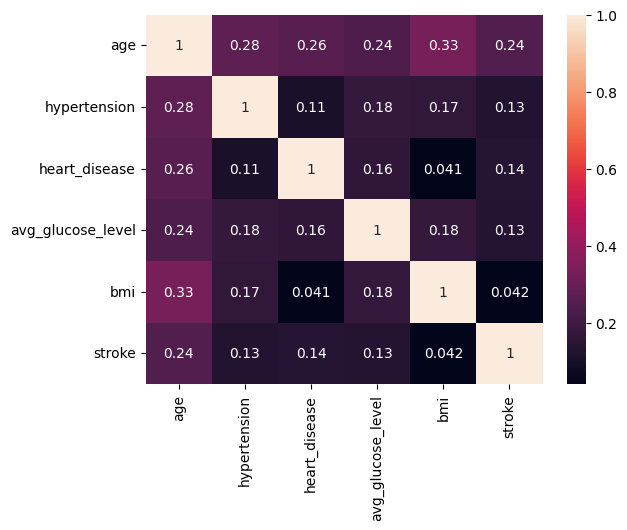

In [10]:
sns.heatmap(df.corr(numeric_only=True), annot=True) # Using `seaborn` lib

### The Examination of Target Variable


In [11]:
df['stroke'].describe()

count    5104.000000
mean        0.048393
std         0.214617
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: stroke, dtype: float64

stroke
0    4857
1     247
Name: count, dtype: int64

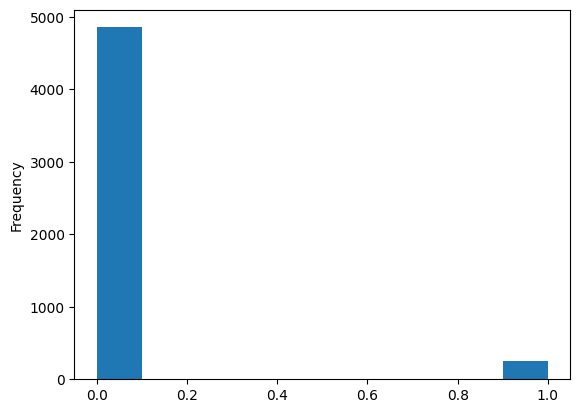

In [12]:
df['stroke'].plot(kind = 'hist')
df['stroke'].value_counts()

* `stroke` column is coded as 1 for cases(has a stroke) and 0 for negative cases(does not have a stroke)
* Approximately 95% of our target variable is `No Stroke` (4861)
* 5% of the instances of our target varibale is `Stroke` (249)

<Axes: xlabel='bmi', ylabel='Count'>

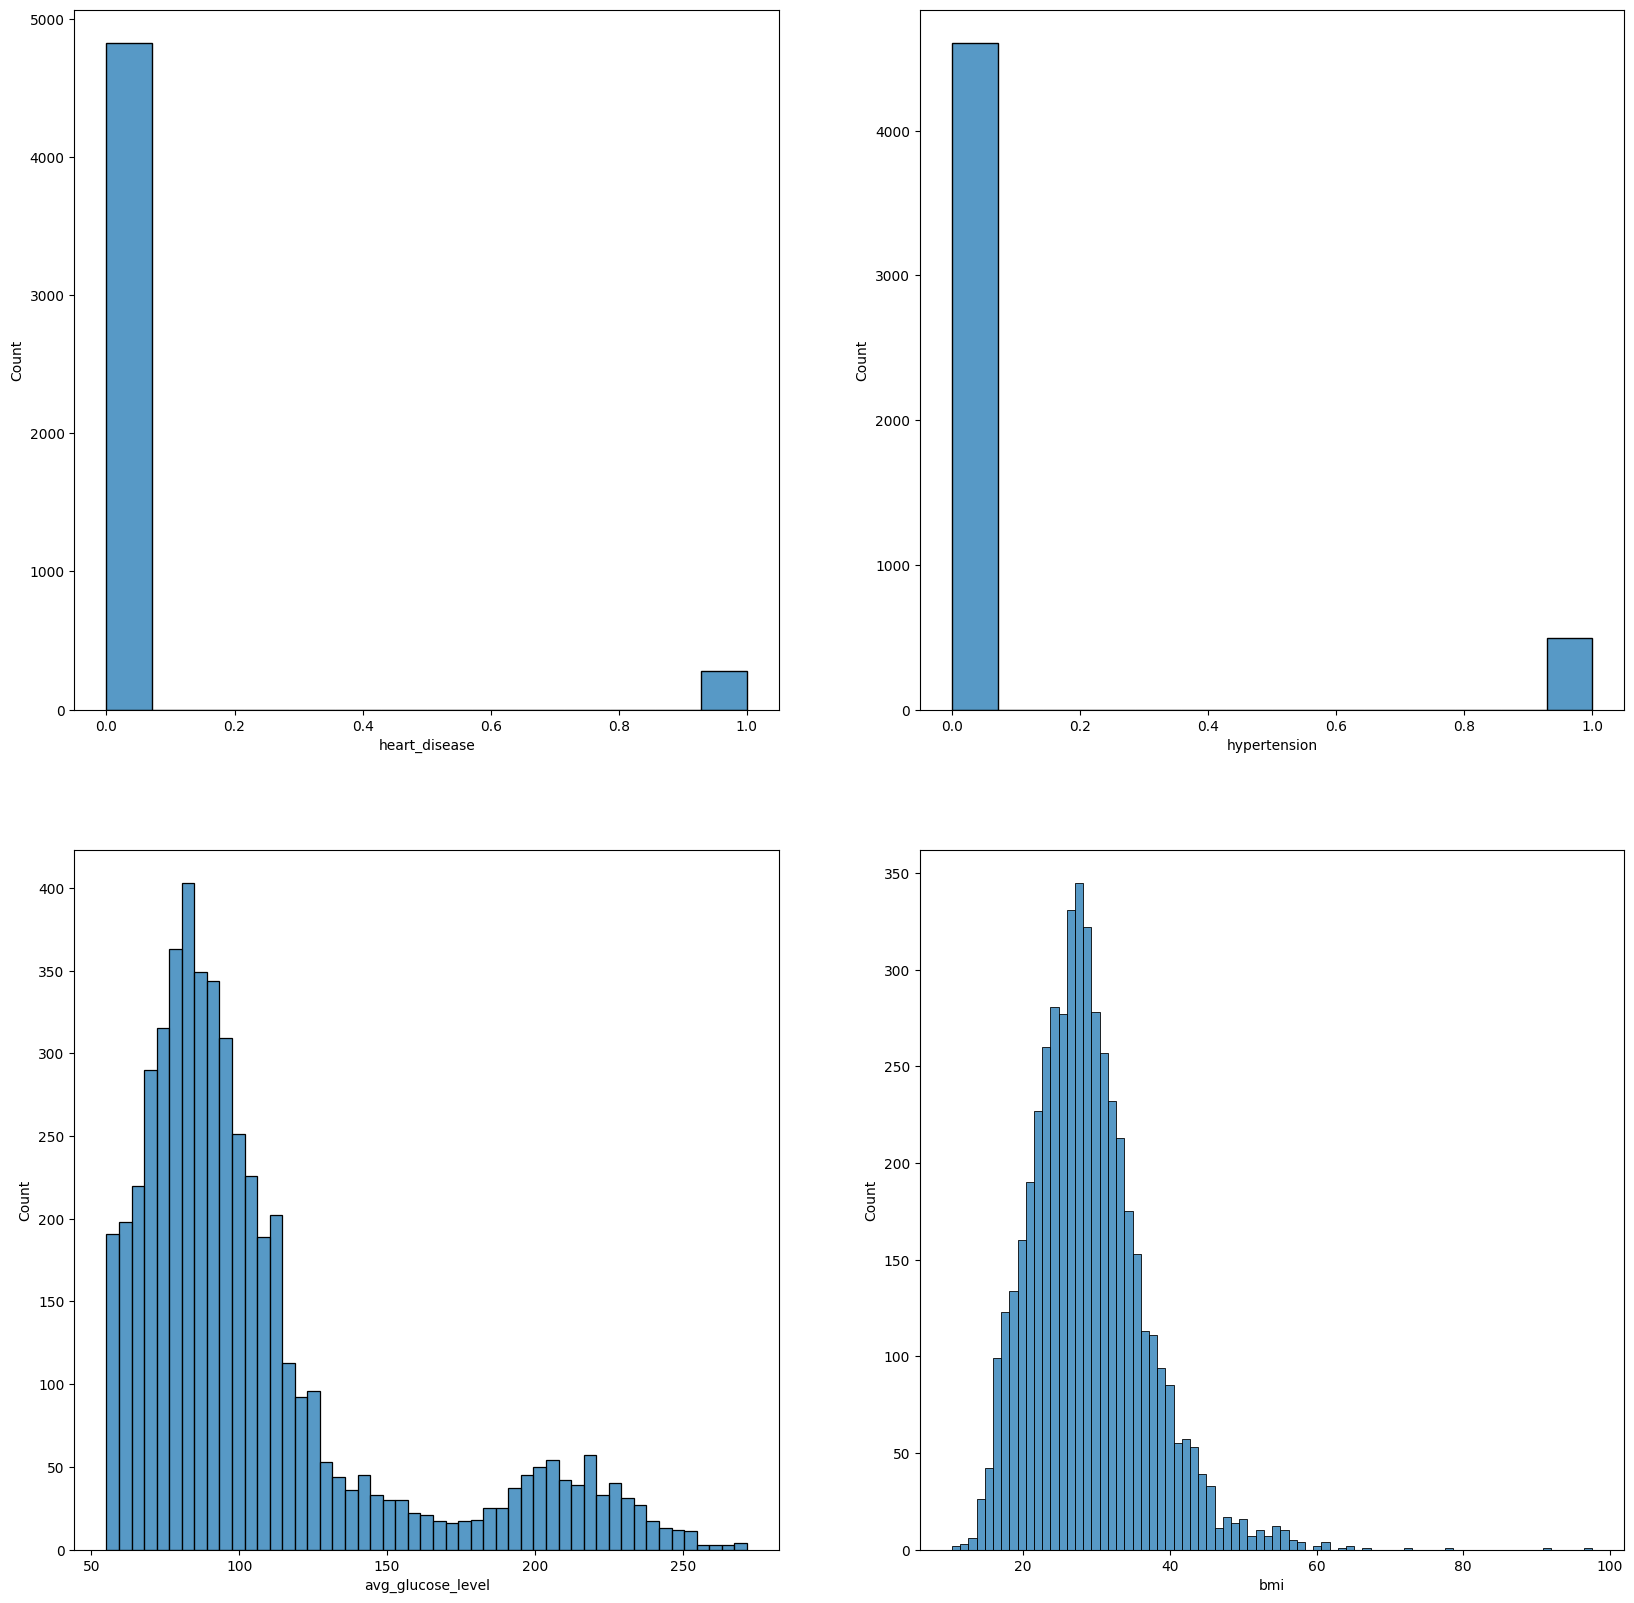

In [13]:
plt.figure(figsize=(20,20))

plt.subplot(2,2,1)
sns.histplot(df['heart_disease'])

plt.subplot(2,2,2)
sns.histplot(df['hypertension'])

plt.subplot(2,2,3)
sns.histplot(df['avg_glucose_level'])

plt.subplot(2,2,4)
sns.histplot(df['bmi'])

# Dummy Operations

In [14]:
df = pd.get_dummies(df, columns=['gender', 'ever_married',
       'work_type', 'residence_type', 'smoking_status',], drop_first=True)

In [15]:
df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,True,False,True,False,True,False,False,True,True,False,False
1,61.0,0,0,202.21,NaN,1,False,False,True,False,False,True,False,False,False,True,False
2,80.0,0,1,105.92,32.5,1,True,False,True,False,True,False,False,False,False,True,False
3,49.0,0,0,171.23,34.4,1,False,False,True,False,True,False,False,True,False,False,True
4,79.0,1,0,174.12,24.0,1,False,False,True,False,False,True,False,False,False,True,False


In [16]:
df.shape

(5104, 17)

<Axes: >

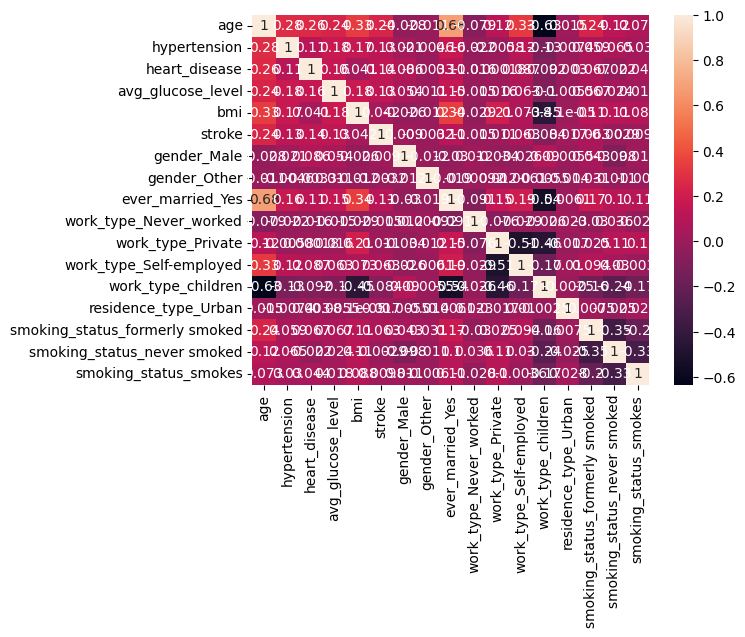

In [17]:
sns.heatmap(df.corr(), annot=True)

# Data Preprocessing

In [18]:
imputer = SimpleImputer(missing_values=np.nan, strategy="median") 

df['bmi'] = imputer.fit_transform(df['bmi'].values.reshape(-1,1))[:,0]


* Fill all missing values in `bmi` column with `median`

In [19]:
X = df.drop('stroke', axis=1)
y = df['stroke']

* Train / Test and Split

In [20]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

* Oversampling the dataset cause the imbalance of the data will affect significiantly to score

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

* Scaling

In [22]:
scaler = MinMaxScaler()
scaler

MinMaxScaler()

In [23]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Implement KNN and Evaluate

In [24]:
knn_model = KNeighborsClassifier(1) 

In [25]:
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [26]:
y_pred = knn_model.predict(X_test)

In [27]:
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9361921097770154
[[1316  137]
 [  49 1413]]
              precision    recall  f1-score   support

           0       0.96      0.91      0.93      1453
           1       0.91      0.97      0.94      1462

    accuracy                           0.94      2915
   macro avg       0.94      0.94      0.94      2915
weighted avg       0.94      0.94      0.94      2915



### Elbow Method for Choosing Reasonable K Values

In [29]:
test_error_rate = []

for k in range(1, 30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)

    y_pred = knn_model.predict(X_test)
    test_error_rate.append(1 - accuracy_score(y_test, y_pred))

Text(0, 0.5, 'Error Rate')

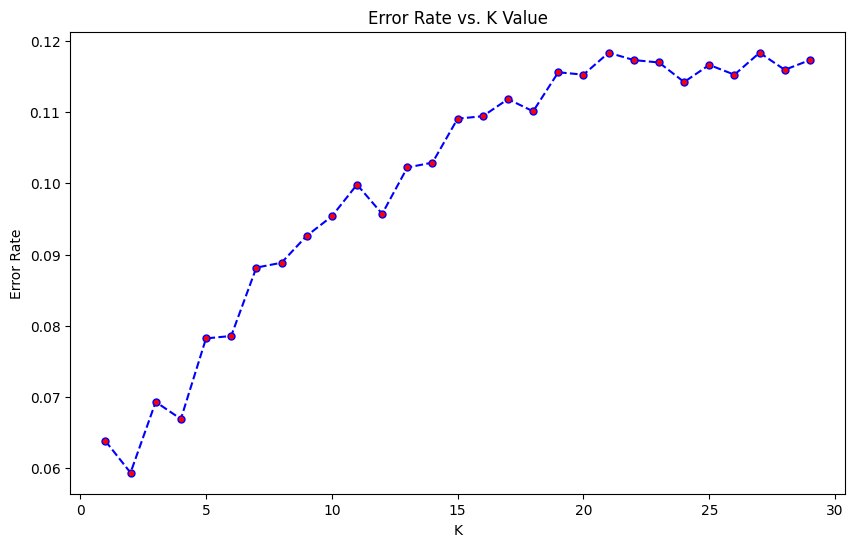

In [30]:
plt.figure(figsize=(10,6))
plt.plot(range(1,30),test_error_rate,color='blue', linestyle='dashed', marker='.',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

* Scores by Various K Values

In [31]:
# FIRST A QUICK COMPARISON TO OUR DEFAULT VALUE K=5
knn = KNeighborsClassifier()

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

print('WITH K=1')
print(f"Accuracy score with k = 5 is {accuracy_score(y_test, y_pred)}")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

WITH K=1
Accuracy score with k = 5 is 0.9217838765008576
[[1286  167]
 [  61 1401]]
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      1453
           1       0.89      0.96      0.92      1462

    accuracy                           0.92      2915
   macro avg       0.92      0.92      0.92      2915
weighted avg       0.92      0.92      0.92      2915



In [32]:
# WITH K=1
knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

print('WITH K=1')
print(f"Accuracy score with k = 1 is {accuracy_score(y_test, y_pred)}")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

WITH K=1
Accuracy score with k = 1 is 0.9361921097770154
[[1316  137]
 [  49 1413]]
              precision    recall  f1-score   support

           0       0.96      0.91      0.93      1453
           1       0.91      0.97      0.94      1462

    accuracy                           0.94      2915
   macro avg       0.94      0.94      0.94      2915
weighted avg       0.94      0.94      0.94      2915



In [33]:
# WITH K=2
knn = KNeighborsClassifier(n_neighbors=2)

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(knn.get_params())
print('WITH K=2')
print(f"Accuracy score with k = 2 is {accuracy_score(y_test, y_pred)}")
print("Model testing accuracy:", ((cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]))*100, "%", sep=' ')
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}
WITH K=2
Accuracy score with k = 2 is 0.9406518010291596
Model testing accuracy: 94.06518010291596 %
0.9405331510594669
0.9411764705882353
0.9408547008547009


In [34]:
# WITH K=3
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)


print('WITH K=3')
print(f"Accuracy score with k = 3 is {accuracy_score(y_test, y_pred)}")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

WITH K=3
Accuracy score with k = 3 is 0.9307032590051458
[[1309  144]
 [  58 1404]]
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1453
           1       0.91      0.96      0.93      1462

    accuracy                           0.93      2915
   macro avg       0.93      0.93      0.93      2915
weighted avg       0.93      0.93      0.93      2915



In [35]:
# WITH K=4
knn = KNeighborsClassifier(n_neighbors=4)

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

print('WITH K=4')
print(f"Accuracy score with k = 4 is {accuracy_score(y_test, y_pred)}")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

WITH K=4
Accuracy score with k = 4 is 0.9331046312178388
[[1332  121]
 [  74 1388]]
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      1453
           1       0.92      0.95      0.93      1462

    accuracy                           0.93      2915
   macro avg       0.93      0.93      0.93      2915
weighted avg       0.93      0.93      0.93      2915



* Cross Validate For Optimal K Value

In [36]:
model = KNeighborsClassifier(n_neighbors=1)

scores = cross_validate(model, X_train, y_train, scoring = ['accuracy', 'precision','recall',
                                                                   'f1'], cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
1,0.001999,0.026599,0.926471,0.898072,0.961652,0.928775
2,0.002356,0.023922,0.941176,0.918768,0.967552,0.942529
3,0.001843,0.020654,0.945588,0.914835,0.982301,0.947368
4,0.001000,0.021378,0.938235,0.927954,0.949853,0.938776
5,0.002423,0.020070,0.947059,0.931818,0.964706,0.947977
6,0.002687,0.020185,0.947059,0.924581,0.973529,0.948424
7,0.001323,0.021199,0.952941,0.935028,0.973529,0.953890
8,0.002082,0.020700,0.914706,0.887363,0.950000,0.917614
9,0.002031,0.020545,0.933824,0.913165,0.958824,0.935438
10,0.002355,0.020855,0.929308,0.898630,0.967552,0.931818


In [37]:
df_scores.mean()[2:]

test_accuracy     0.937637
test_precision    0.915021
test_recall       0.964950
test_f1           0.939261
dtype: float64

## Gridsearch Method for Choosing Optimal K Values

In [38]:
knn_grid = KNeighborsClassifier()

In [39]:
k_values= range(2,3)

In [40]:
param_grid = {"n_neighbors":k_values, "metric": ['euclidean', 'manhattan', 'cosine', 'minkowski'], "weights": ['uniform', "distance"], 'p' : [1, 2]}

In [41]:
knn_grid_model = GridSearchCV(knn_grid, param_grid, cv=10, scoring= 'accuracy')

In [42]:
knn_grid_model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'cosine',
                                    'minkowski'],
                         'n_neighbors': range(2, 3), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [43]:
knn_grid_model.best_params_

{'metric': 'manhattan', 'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}

In [44]:

knn = KNeighborsClassifier(n_neighbors=2, weights='uniform', metric='manhattan', p=1)

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

print(f'Optimal parameters: f{knn_grid_model.best_params_}')
print(f"Accuracy score with k = 1 is {accuracy_score(y_test, y_pred)}")
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

Optimal parameters: f{'metric': 'manhattan', 'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}
Accuracy score with k = 1 is 0.9430531732418524
0.9444444444444444
0.9418604651162791
0.9431506849315069


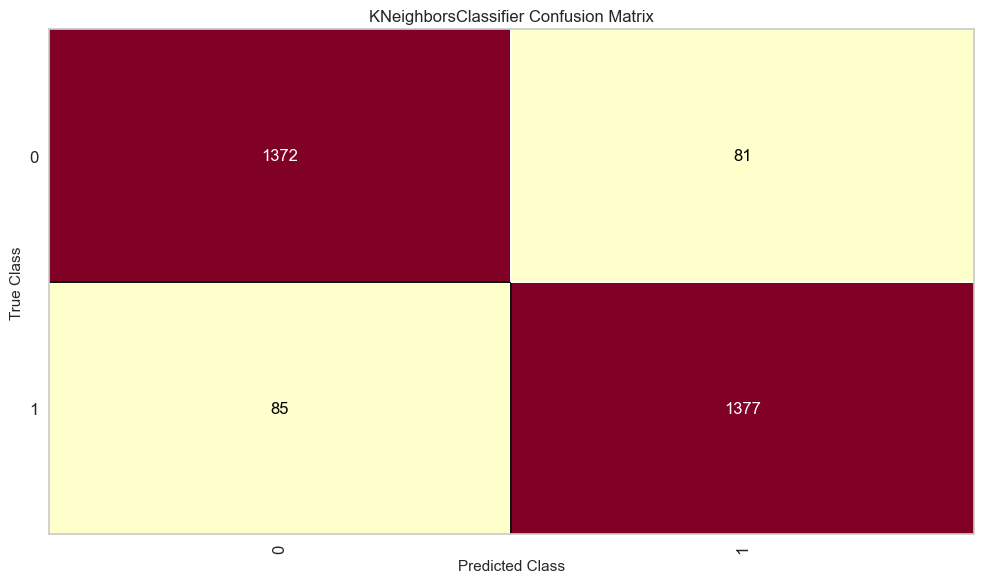

<Axes: title={'center': 'KNeighborsClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [47]:
plt.figure(figsize=(10, 6))
cm = ConfusionMatrix(knn)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()


In [48]:
import pickle

# Serialize and save the model
with open('model.pkl', 'wb') as f:
    pickle.dump(knn, f)

# Conclusion

* Our results with the KNN model for this dataset are not very good.
* Although we did cross validation and found the most suitable parameters with GridSearch, we could not achieve the desired improvement in our results.
* After this point let's go on with other models.